1A

In [ ]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

1.14.0


In [ ]:
import tensorflow as tf
import numpy as np

class SOM(object):

    # To check if the SOM has been trained
    trained = False

    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):

        # Assign required variables first
        self.m = m; self.n = n
        if alpha is None:
            alpha = 0.2
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self.n_iterations = abs(int(n_iterations))

        self.graph = tf.Graph()

        with self.graph.as_default():

            # To save data, create weight vectors and their location vectors

            self.weightage_vects = tf.Variable(tf.random_normal( [m * n, dim]) )

            self.location_vects = tf.constant(np.array(list(self.neuron_locations(m, n))))

            # Training inputs

            # The training vector
            self.vect_input = tf.placeholder("float", [dim])
            # Iteration number
            self.iter_input = tf.placeholder("float")

            # Training Operation  # tf.stack result will be [ (m*n),  dim ]

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self.weightage_vects, tf.stack(
                    [self.vect_input for _ in range(m * n)])), 2), 1)), 0) 
                    

            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self.location_vects, 
                                    slice_input, tf.constant(np.array([1, 2]))), [2])

            # To compute the alpha and sigma values based on iteration number
            learning_rate_op = tf.subtract(1.0, tf.div(self.iter_input, self.n_iterations))
            alpha_op = tf.multiply(alpha, learning_rate_op)
            sigma_op = tf.multiply(sigma, learning_rate_op)

            # learning rates for all neurons, based on iteration number and location w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self.location_vects, tf.stack( [bmu_loc for _ in range(m * n)] ) ) , 2 ), 1)

            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(sigma_op, 2))))
            learning_rate_op = tf.multiply(alpha_op, neighbourhood_func)

            # Finally, the op that will use learning_rate_op to update the weightage vectors of all neurons
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim]) for i in range(m * n)] )

            ### Strucutre of updating weight ###
            ### W(t+1) = W(t) + W_delta ###
            ### wherer, W_delta = L(t) * ( V(t)-W(t) ) ###

            # W_delta = L(t) * ( V(t)-W(t) )
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self.vect_input for _ in range(m * n)]), self.weightage_vects))

            # W(t+1) = W(t) + W_delta
            new_weightages_op = tf.add(self.weightage_vects, weightage_delta)

            # Update weightge_vects by assigning new_weightages_op to it.
            self.training_op = tf.assign(self.weightage_vects, new_weightages_op)

            self.sess = tf.Session()
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)

    def neuron_locations(self, m, n):

        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def train(self, input_vects):

        # Training iterations
        for iter_no in range(self.n_iterations):
            # Train with each vector one by one
            for input_vect in input_vects:
                self.sess.run(self.training_op, 
                        feed_dict={self.vect_input: input_vect, self.iter_input: iter_no})

        # Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self.m)]
        self.weightages = list(self.sess.run(self.weightage_vects))
        self.locations = list(self.sess.run(self.location_vects))
        for i, loc in enumerate(self.locations):
            centroid_grid[loc[0]].append(self.weightages[i])

        self.centroid_grid = centroid_grid

        self.trained = True

    def get_centroids(self):

        if not self.trained:
            raise ValueError("SOM not trained yet")
        return self.centroid_grid

    def map_vects(self, input_vects):

        if not self.trained:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in input_vects:
            min_index = min( [i for i in range(len(self.weightages))], 
                            key=lambda x: np.linalg.norm(vect - self.weightages[x]) )
            to_return.append(self.locations[min_index])

        return to_return

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

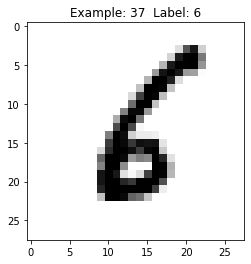

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


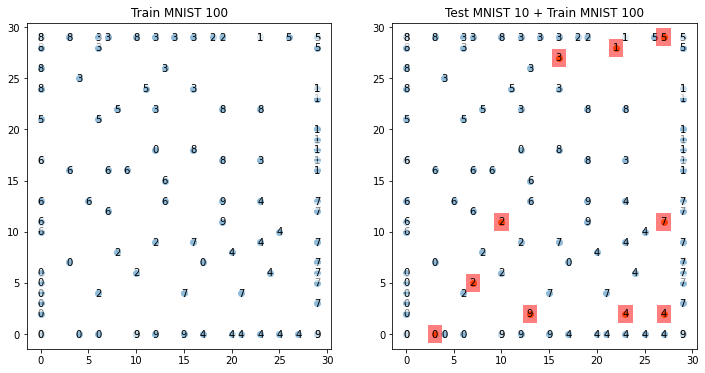

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random as ran

## Applying SOM into Mnist data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

def train_size(num):
    x_train = mnist.train.images[:num,:]
    y_train = mnist.train.labels[:num,:]
    return x_train, y_train

x_train, y_train = train_size(100)
x_test, y_test = train_size(110)
x_test = x_test[100:110,:]; y_test = y_test[100:110,:]

def display_digit(num):
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

display_digit(ran.randint(0, x_train.shape[0]))

# Import som class and train into 30 * 30 sized of SOM lattice

som = SOM(30, 30, x_train.shape[1], 200)
som.train(x_train)

# Fit train data into SOM lattice
mapped = som.map_vects(x_train)
mappedarr = np.array(mapped)
x1 = mappedarr[:,0]; y1 = mappedarr[:,1]

index = [ np.where(r==1)[0][0] for r in y_train ]
index = list(map(str, index))

## Plots: 1) Train 2) Test+Train ###

plt.figure(1, figsize=(12,6))
plt.subplot(121)
# Plot 1 for Training only
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.title('Train MNIST 100')

# Testing
mappedtest = som.map_vects(x_test)
mappedtestarr = np.array(mappedtest)
x2 = mappedtestarr[:,0]
y2 = mappedtestarr[:,1]

index2 = [ np.where(r==1)[0][0] for r in y_test ]
index2 = list(map(str, index2))

plt.subplot(122)
# Plot 2: Training + Testing
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

plt.scatter(x2,y2)
# Just adding text
for i, m in enumerate(mappedtest):
    plt.text( m[0], m[1],index2[i], ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5, lw=0))
plt.title('Test MNIST 10 + Train MNIST 100')

plt.show()

1B

In [ ]:
input = [
    [1.,0.,1.,0.],
    [1.,0.,0.,0.],
    [0.,0.,0.,1.],
    [0.,1.,0.,1.]
    ]

weight= [
         [.2,.6,.5,.9],
         [.8,.4,.7,.3]
]

epoch = 4


lr=0;
for berapalah in range(epoch):

  if(berapalah==0):
      lr=0.6
  else :
      lr=0.5*lr
  for i in range (len(input)):
    x=0
    y=0
    for j in range (len(input[i])):
      x += ((input[i][j]- weight[0][j])**2)
      y += ((input[i][j]- weight[1][j])**2)

    x= math.sqrt(x)
    y= math.sqrt(y)

    if(x<y):
      new_weight=[]
      for a in range(len(input[i])):
        new_weight.append(((input[i][a]-weight[0][a])*lr)+weight[0][a])
      weight[0]=new_weight


    if(y<x):
      new_weight=[]
      for a in range(len(input[i])):
        new_weight.append(((input[i][a]-weight[1][a])*lr)+weight[1][a])
      
      weight[1]=new_weight

  print(weight)



[[0.03200000000000001, 0.696, 0.08000000000000002, 0.984], [0.968, 0.06400000000000002, 0.352, 0.048]]
[[0.015680000000000003, 0.6410399999999999, 0.039200000000000006, 0.99216], [0.98432, 0.031360000000000006, 0.38248000000000004, 0.023520000000000006]]
[[0.011328800000000003, 0.6131513999999999, 0.028322000000000003, 0.9943356], [0.9886712, 0.022657600000000007, 0.40384180000000003, 0.016993200000000007]]
[[0.009693204500000004, 0.5996276666249999, 0.024233011250000002, 0.99515339775], [0.9903067955, 0.019386409000000007, 0.41491214012500005, 0.014539806750000007]]


2B

Input 

In [ ]:
import numpy as np

#X1 X2
sample=np.array([[2.5, 2.4],
      [0.5, 0.7],
      [2.2, 2.9],
      [1.9, 2.2],
      [3.1, 3.0],
      [2.3, 2.7],
      [2, 1.6],
      [1, 1.1],
      [1.5, 1.6],
      [1.1, 1.9]])
samples=sample.reshape(2,10) #reshape into 2 x 10

mean_x = np.mean(samples[0,:])
mean_y = np.mean(samples[1,:])

mean= np.array([[mean_x],[mean_y]])

print('Mean Vector:\n',mean)


Mean Vector:
 [[2.14]
 [1.68]]


Dimentional Mean Vector

In [ ]:
scatter_matrix = np.zeros((2,2))
for i in range(samples.shape[1]):
    scatter_matrix += (samples[:,i].reshape(2,1) - mean).dot((samples[:,i].reshape(2,1) - mean).T)
print('Scatter Matrix:\n', scatter_matrix)

Scatter Matrix:
 [[ 7.264 -0.732]
 [-0.732  2.756]]


Computing Scatter Matrix

In [ ]:
cov_mat = np.cov([samples[0,:],samples[1,:]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[ 0.80711111 -0.08133333]
 [-0.08133333  0.30622222]]


In [ ]:
cov_mat = np.cov([samples[0,:],samples[1,:]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[ 0.80711111 -0.08133333]
 [-0.08133333  0.30622222]]


Computing eigenvectors and corresponding eigenvalues

In [ ]:
# eigenvectors and eigenvalues for the from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,2).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1,2).T
    assert eigvec_sc.all() == eigvec_cov.all(), 'Eigenvectors are not identical'

    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('Scaling factor: ', eig_val_sc[i]/eig_val_cov[i])
    print(40 * '-')

Eigenvector 1: 
[[ 0.98769992]
 [-0.15636134]]
Eigenvalue 1 from scatter matrix: 7.3798818535952355
Eigenvalue 1 from covariance matrix: 0.819986872621693
Scaling factor:  8.999999999999998
----------------------------------------
Eigenvector 2: 
[[0.15636134]
 [0.98769992]]
Eigenvalue 2 from scatter matrix: 2.6401181464047623
Eigenvalue 2 from covariance matrix: 0.2933464607116402
Scaling factor:  9.000000000000002
----------------------------------------


Checking the eigenvector-eigenvalue calculation

In [ ]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:,i].reshape(1,2).T
    np.testing.assert_array_almost_equal(scatter_matrix.dot(eigv), eig_val_sc[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

Sorting the eigenvectors by decreasing eigenvalues

In [ ]:
for ev in eig_vec_sc:
    numpy.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    # instead of 'assert' because of rounding errors

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

7.3798818535952355
2.6401181464047623


Choosing k eigenvectors with the largest eigenvalues

In [ ]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(2,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [ 0.98769992 -0.15636134]


Transforming sample into the new subspace

In [ ]:
transformed = matrix_w.T.dot(samples)
transformed.reshape(1,10)

array([[2.10961873, 1.9483042 , 0.18112729, 0.44121181, 2.01657849,
        2.6923323 , 1.64208785, 1.92276169, 2.88987228, 2.66601322]])

Text(0.5, 1.0, 'Transformed samples')

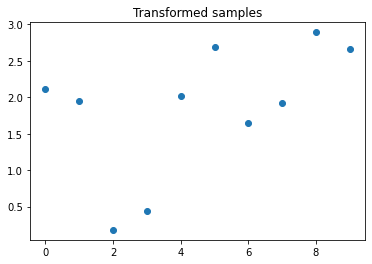

In [ ]:
from matplotlib import pyplot as pyplot

plt.plot(transformed,'o')
plt.title('Transformed samples')


2C

The dataset used are from https://gist.github.com/tijptjik/9408623#file-wine-csv

In [ ]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 512kB 49.4MB/s 
     |████████████████████████████████| 3.8MB 40.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ef98f9e324447106d1153eddf968ee5160126e4e228ae131cbe64e5586c047c0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installatio

PCA

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv('wine.csv')
dataset = dataset[['Alcohol','Malic.acid','Ash','Acl','Mg','Phenols','Flavanoids','Nonflavanoid.phenols','Proanth','Color.int','Hue','OD','Proline']]

scaler = MinMaxScaler()
dataset= scaler.fit_transform(dataset)

print(dataset)

pca = PCA(n_components=2)
pca = pca.fit(dataset)
dataset = pca.transform(dataset)
print(dataset)

[[0.84210526 0.1916996  0.57219251 ... 0.45528455 0.97069597 0.56134094]
 [0.57105263 0.2055336  0.4171123  ... 0.46341463 0.78021978 0.55064194]
 [0.56052632 0.3201581  0.70053476 ... 0.44715447 0.6959707  0.64693295]
 ...
 [0.58947368 0.69960474 0.48128342 ... 0.08943089 0.10622711 0.39728959]
 [0.56315789 0.36561265 0.54010695 ... 0.09756098 0.12820513 0.40085592]
 [0.81578947 0.66403162 0.73796791 ... 0.10569106 0.12087912 0.20114123]]
[[-7.06335756e-01 -2.53192753e-01]
 [-4.84976802e-01 -8.82289142e-03]
 [-5.21172266e-01 -1.89187222e-01]
 [-8.21643663e-01 -5.80905512e-01]
 [-2.02546382e-01 -5.94665740e-02]
 [-6.08190152e-01 -4.87519191e-01]
 [-5.44047399e-01 -3.00196497e-01]
 [-4.74357495e-01 -2.98197021e-01]
 [-5.00432012e-01 -3.07602859e-01]
 [-6.27517969e-01 -2.06328233e-01]
 [-7.27467157e-01 -3.56512044e-01]
 [-3.74967744e-01 -2.25424535e-01]
 [-4.48188283e-01 -2.31938139e-01]
 [-6.26345329e-01 -3.55138677e-01]
 [-8.35717011e-01 -5.38047802e-01]
 [-4.71931568e-01 -3.37405385e-

3A

In [ ]:
pip install tensorflow==1.10

In [ ]:
import tensorflow as tf


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [ ]:
# We use the Sequential model in keras which is used 99% of the time 
model = tf.keras.Sequential() 
# We add our first convolutional layer with 32 neurons and filter size of 3 x 3
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
# We add our max pooling layer 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
#We add a second convolutional layer 
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) 
# Our dropout layer 
model.add(tf.keras.layers.Dropout(0.25)) 
# A fully connected layer 
model.add(tf.keras.layers.Dense(128, activation='relu')) 
# Another dropout layer with more dropouts 
model.add(tf.keras.layers.Dropout(0.5)) 
# We flatten the features 
model.add(tf.keras.layers.Flatten()) 
# We add an output layer that uses softmax activation for the 10 classes 
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])


In [ ]:
themodel=model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0611 - acc: 0.9811 - val_loss: 0.0383 - val_acc: 0.9866
Epoch 2/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0516 - acc: 0.9844 - val_loss: 0.0335 - val_acc: 0.9878
Epoch 3/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0455 - acc: 0.9856 - val_loss: 0.0349 - val_acc: 0.9874
Epoch 4/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0413 - acc: 0.9867 - val_loss: 0.0289 - val_acc: 0.9902
Epoch 5/10
60000/60000 [==============================] - 119s 2ms/step - loss: 0.0373 - acc: 0.9887 - val_loss: 0.0271 - val_acc: 0.9903
Epoch 6/10
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0339 - acc: 0.9898 - val_loss: 0.0286 - val_acc: 0.9894
Epoch 7/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0322 - acc: 0.9903 - val_loss: 0.0280 - 

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.02387358154144458
Test accuracy: 0.9917


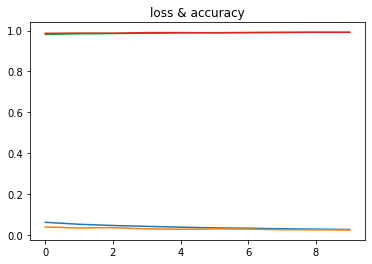

In [ ]:
plt.title('loss & accuracy')
plt.plot(themodel.history['loss'], label='Train')
plt.plot(themodel.history['val_loss'], label='Test')
plt.plot(themodel.history['acc'], label='Train')
plt.plot(themodel.history['val_acc'], label='Test')
plt.show()

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

Confusion Matrix
[[ 978    0    0    0    0    0    0    1    1    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   1    3 1023    2    0    0    0    3    0    0]
 [   0    0    0 1006    0    2    0    0    2    0]
 [   0    0    0    0  976    0    1    0    1    4]
 [   0    0    0    6    0  885    1    0    0    0]
 [   7    3    0    0    1    5  942    0    0    0]
 [   0    4    2    2    1    0    0 1017    1    1]
 [   2    0    2    1    1    1    0    0  965    2]
 [   1    1    0    1    3    5    0    4    2  992]]
Confusion matrix, without normalization
[[ 978    0    0    0    0    0    0    1    1    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   1    3 1023    2    0    0    0    3    0    0]
 [   0    0    0 1006    0    2    0    0    2    0]
 [   0    0    0    0  976    0    1    0    1    4]
 [   0    0    0    6    0  885    1    0    0    0]
 [   7    3    0    0    1    5  942    0    0    0]
 [   0    4    2    2    1    0    0 1017

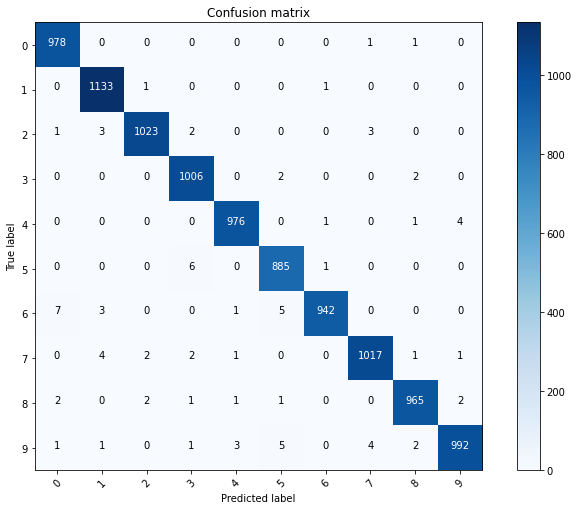

In [ ]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
pred = model.predict(x_test)
cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
print("Confusion Matrix")
print(cm)
plot_confusion_matrix(cm)